<a href="https://colab.research.google.com/github/stepyt/vs_cylinder_ann_pso/blob/master/MLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **METAMODELING WITH ARTIFICIAL NEURAL NETWORK**

In this notebook, we will use the results of Abaqus analyses in order to build an Artificial Neural Network (ANN) of the Finite Element (FE) analysis solver.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import sys
import os

In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as Data

! pip install pyrenn
import pyrenn as prn

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']}) # Palatino font
plt.rcParams['pdf.fonttype'] = 42

We fix the seed in order to obtain reproducible results.

In [5]:
seed = 0
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(seed=seed)

## **Data preprocessing**

We start by importing some information about the model used to generate the dataset.

In [6]:
# Modify parameter to choose the output folder to consider
stacking_sequence = 'symmetric'
data_set = 'large1.65'
load_case = 'torsion'
fiber_path = 'harmlin'

# Check if notebook running in Colab
is_colab = 'google.colab' in sys.modules

# Model info folder
if is_colab:
    input_folder = './'
else:
    input_folder = '../dataset/' + load_case + '/' + stacking_sequence + '/'\
                    + data_set + '/' + fiber_path + '/'

info = pd.read_csv(input_folder + 'model_info.csv', sep=",")
info.index = ['Value']
eff_plies = int(info['EffectivePlies'].values)
train_smp = int(info['Train'].values)
info.head()

,Height,Radius,MaxCurvature,MeshSize,Plies,EffectivePlies,Symmetric,Balanced,AnglesFunction,Train,Test
Value,700,300,0.001575,10,8,4,True,False,harmlin,560,140


At this point we have to import the data set containing the input and output of the FE analysis. The data is stored in a dataframe in which the upper part is associated to the training set and the lower part to the test set. The precise number of upper row belonging to the train set is indicated in the info above.

In [7]:
# Model info folder
if is_colab:
    data_folder = './'
else:
    data_folder = '../dataset/' + load_case + '/' + stacking_sequence + '/'\
                    + data_set + '/' + fiber_path + '/'

data_orig = pd.read_csv(data_folder + '/data.csv', sep=',')
data = data_orig.drop(columns='Stiffness')
data_orig

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Amplitude3,PhaseShift3,Omega3,Beta3,Amplitude4,PhaseShift4,Omega4,Beta4,Buckling,Stiffness
0,23.669,35.674,1.409,43.196,14.879,-37.111,1.147,1.143,-43.219,88.109,1.061,-45.257,136.391,-7.020,0.587,89.224,18065.4,6807812.096
1,-10.608,-47.271,1.311,-62.455,-49.425,-48.961,1.355,-56.506,154.620,3.480,0.695,-66.452,-2.876,9.663,1.668,-10.296,-22731.8,2609794.560
2,46.250,-2.260,0.923,-40.437,20.162,-83.127,1.961,-52.351,18.899,-58.558,1.067,-14.622,-6.272,65.728,1.788,7.627,-18647.4,4156273.152
3,-19.562,-70.532,1.076,18.431,-83.234,-65.242,1.509,-69.464,-17.323,20.625,1.570,57.143,87.210,28.914,1.926,79.595,-20191.1,5115148.288
4,-4.180,84.170,0.851,-43.533,62.261,-13.888,0.575,-12.020,6.920,-26.763,1.920,23.756,-7.832,-16.484,1.595,-6.548,-16820.4,5806592.512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,20.341,89.555,0.277,-88.706,-5.957,54.018,1.971,19.139,8.400,-47.485,1.804,25.982,-43.375,54.831,0.215,10.073,-21732.0,2313146.880
696,-24.083,4.468,1.232,36.891,-125.757,20.249,1.122,-71.272,-101.682,80.466,1.319,67.270,-94.104,-10.741,0.431,1.959,-28516.8,5713931.264
697,-18.345,-19.800,1.038,5.217,7.609,-78.712,1.874,-25.637,-14.798,-49.755,0.374,10.105,9.312,-26.508,1.515,13.854,-12756.4,4143940.864
698,-64.509,57.324,0.632,-27.338,-7.414,-59.336,1.625,1.859,61.666,-19.991,0.585,81.997,-20.811,8.215,1.548,43.853,-17352.6,4617006.080


After importing the data we change the sign of the features associated to negeative values of the buckling load, and the sign of the buckling loads. In this way all the critical values have the same sign.

In [8]:
# indexes = data['Buckling'].values < 0
# data[indexes] = -data[indexes]
# data

The most important step to perform before training our model is the normalization of the variables. Different strategies are possible at this end, among which 2 are the most used:

* Range normalization: converts all the values to the range $[0, 1]$

* Standard score normalization: forces the variables to have $0$ mean and $1$ standard deviation

We will try both to see the effect on the model performance.

In [9]:
def range_norm(x):
    """normalization in range [0, 1]"""
    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

def std_norm(x):
    """normalization with zero mean and unitary standard deviation"""
    m = np.mean(x, axis=0)
    s = np.std(x, axis=0)
    x_norm = (x - m) / s
    
    return x_norm

In [10]:
data_norm = std_norm(data_orig)
data_norm.describe()

,Amplitude1,PhaseShift1,Omega1,Beta1,Amplitude2,PhaseShift2,Omega2,Beta2,Amplitude3,PhaseShift3,Omega3,Beta3,Amplitude4,PhaseShift4,Omega4,Beta4,Buckling,Stiffness
count,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02,7.000000e+02
mean,-1.245036e-17,-3.869920e-17,2.895779e-15,5.836601e-17,2.474211e-17,7.930164e-18,-3.578090e-16,-4.694657e-17,4.536054e-17,2.985707e-17,-7.295751e-16,-3.520993e-17,2.791418e-17,-4.044384e-17,-8.792570e-16,2.664535e-17,-3.838200e-17,-1.608237e-15
std,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00,1.000715e+00
min,-2.406044e+00,-1.728704e+00,-1.727093e+00,-1.727786e+00,-2.381408e+00,-1.726789e+00,-1.730312e+00,-1.726447e+00,-2.455540e+00,-1.729899e+00,-1.726841e+00,-1.732248e+00,-2.438131e+00,-1.726969e+00,-1.728514e+00,-1.727824e+00,-1.642791e+00,-1.854951e+00
25%,-5.547857e-01,-8.622589e-01,-8.674712e-01,-8.664211e-01,-5.057011e-01,-8.651415e-01,-8.646623e-01,-8.653310e-01,-5.446212e-01,-8.628317e-01,-8.646640e-01,-8.669041e-01,-5.419365e-01,-8.646290e-01,-8.663157e-01,-8.655583e-01,-9.601391e-01,-8.678913e-01
50%,-1.957726e-02,1.929409e-04,-5.444167e-05,4.196555e-04,5.922758e-02,5.949642e-04,-1.610914e-03,1.248710e-04,-1.522969e-02,-5.759076e-04,-1.620796e-03,-1.752941e-03,7.516864e-03,9.626214e-04,1.945003e-03,-1.396499e-03,5.723826e-01,-1.397617e-01
75%,4.650153e-01,8.653920e-01,8.656300e-01,8.642241e-01,5.272244e-01,8.632861e-01,8.653378e-01,8.651333e-01,4.702517e-01,8.666549e-01,8.661858e-01,8.639324e-01,4.987129e-01,8.626769e-01,8.658753e-01,8.649452e-01,9.309137e-01,7.918783e-01
max,2.381366e+00,1.731534e+00,1.730448e+00,1.731724e+00,2.483459e+00,1.728306e+00,1.727090e+00,1.726389e+00,2.426293e+00,1.731037e+00,1.728796e+00,1.729435e+00,2.455543e+00,1.726643e+00,1.727207e+00,1.728611e+00,1.620255e+00,3.167960e+00


Now we can split the data into training and test set. The two sets have been generate independently during the DOE.

In [23]:
X = data_norm.drop(['Buckling', 'Stiffness'], axis=1).values
Y = data_norm[['Buckling','Stiffness']].values

# Train set
_X_train = X[:train_smp, :]
_Y_train = Y[:train_smp]

# Test set
X_test = X[train_smp:, :]
Y_test = Y[train_smp:]

print('- - - - -')
print('Problem info:')
print('- - - - -')
print("X_train : {}".format(_X_train.shape))
print("Y_train : {}".format(_Y_train.shape))
print("X_test : {}".format(X_test.shape))
print("Y_test : {}".format(Y_test.shape))
print('- - - - -')

- - - - -
Problem info:
- - - - -
X_train : (560, 16)
Y_train : (560, 2)
X_test : (140, 16)
Y_test : (140, 2)
- - - - -


We can now split the training set into train and val. In this way the validation set will be used to monitoring the overfitting/underfitting.

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(_X_train, _Y_train, test_size=0.2, random_state=seed)

At this point we can generate the iterable data sets for Torch

In [26]:
# just for the training set
batch = 32

def _init_fn(worker_id):
    np.random.seed(int(seed))
    
train_dataset = Data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=batch, shuffle=True, num_workers=0, pin_memory=True, worker_init_fn=_init_fn)

val_dataset = Data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
val_loader = Data.DataLoader(dataset=val_dataset, batch_size=X_val.shape[0], shuffle=True, num_workers=0, pin_memory=True, worker_init_fn=_init_fn)

test_dataset = Data.TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(Y_test).float())
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=X_test.shape[0], shuffle=True, num_workers=0, pin_memory=True, worker_init_fn=_init_fn)

## **Neural network**

First define network class

In [14]:
class MLPNN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(MLPNN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H//2)
        self.linear3 = torch.nn.Linear(H//2, H)
        self.linear4 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        h_relu = self.linear2(h_relu).clamp(min=0)
        h_relu = self.linear3(h_relu).clamp(min=0)
        y_pred = self.linear4(h_relu)
        return y_pred

In [15]:
class EarlyStopping:
    def __init__(self, patience=30, delta=1e-3, path='checkpoint.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        if self.val_loss_min > val_loss:
            self.val_loss_min = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [32]:
n_x = X_train.shape[1]
n_y = Y_train.shape[1]
D_in, H, D_out = n_x, 8, n_y

modelMLP = MLPNN(D_in, H, D_out)

epochs = 1
lr = 1e-3

is_optimizing = True

if(os.path.isfile('net_weights/weights_NN') and is_optimizing==False):
    modelMLP.load_state_dict(torch.load('net_weights/weights_NN'))
    print(modelMLP.eval())
else:
    criterion = torch.nn.MSELoss(reduction='mean') 
    optimizer = torch.optim.Adam(modelMLP.parameters(), lr=lr)
    train_loss = []
    for epoch in range(epochs):
        for step, (batch_x, batch_y) in enumerate(train_loader):
            print(batch_x[0, :])
            y_pred = modelMLP(batch_x)
            loss = criterion(y_pred, batch_y)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 50 == 0:
            modelMLP.eval()
            for step, (val_x, val_y) in enumerate(val_loader):
                val_pred = modelMLP(val_x)
                loss_val = criterion(val_pred, val_y)
            modelMLP.train()
            print("Iteration: ", epoch, " Loss: ", loss.item(), " Val loss: ", loss_val.item())
    torch.save(modelMLP.state_dict(), 'weights_NN')

tensor([-2.1854, -0.5917, -1.2195, -0.5788,  2.2205,  1.3090,  0.5111,  1.6995,
         0.6404, -0.8929,  1.1035, -1.3761, -0.5442, -1.4146, -1.5362,  1.3427])
tensor([ 0.0678, -0.5028, -0.4764, -0.4828, -0.1579, -0.4769,  0.1907, -1.0244,
        -0.3277,  0.3701,  0.2184,  0.6548, -0.7940,  1.1124, -0.8919, -1.1872])
tensor([-0.1353,  1.5654,  1.0358,  0.4201, -0.2290, -0.1612,  1.0948, -0.9484,
         0.3138,  1.3413, -0.2129,  0.2227, -0.8676,  1.0515,  0.2964, -1.1386])
tensor([ 1.1479,  1.0642,  0.0675, -1.2585,  1.7774,  1.3830, -0.1991,  1.7188,
        -0.1319,  1.6125,  1.3997,  0.5878, -0.0870, -1.1706,  0.0539,  1.3777])
tensor([-1.0677, -0.1865,  0.1714, -1.1672, -0.1349,  0.2420,  0.2877, -0.2812,
        -0.8078,  1.5600, -1.2557,  1.5817,  1.9076,  1.5032, -1.4583,  1.0431])
tensor([-0.2395,  0.7743, -0.0070,  1.7203, -0.0719,  0.8165,  1.4673,  0.6797,
        -0.1342,  1.3806,  1.4932,  0.6584, -1.0418, -1.6530, -0.8728, -0.2634])
tensor([-0.2801, -0.2190,  1.6941,

Let's define some important metrics used to evaluate the performance of the model.

In [ ]:
def r_2(y_true, y_pred):
    num = np.sum(((y_true - y_pred) ** 2), 0)
    den = np.sum((y_true - np.mean(y_true, 0) ** 2), 0)
    return np.mean(1 - num / den)

def rmae(y_true, y_pred):
    max_err = np.amax(abs(y_true - y_pred), 0)
    std = ((0.5 * np.sum((y_pred - np.mean(y_true, 0)) ** 2,0)) ** 0.5)
    return np.mean(max_err / std)
    
def raae(y_true, y_pred):
    num = np.sum(abs(y_true - y_pred), 0)
    den = std = ((0.5 * np.sum((y_pred - np.mean(y_true, 0)) ** 2,0)) ** 0.5) * np.size(y_true, 0)
    return np.mean(num / den)

def mape(y_true, y_pred):
    return np.mean((abs(y_true - y_pred) / y_true) * 100)

def mpe(y_true, y_pred):
    val_max = np.max((abs(y_true - y_pred) / y_true) * 100)
    idx = np.argmax(val_max)
    return val_max, idx

def mse(y_pred, y_true):
  return tf.reduce_mean(tf.square(y_pred - y_true))

In the cell below we will define the architecture of our network. The ANN will be composed by $3$ hidden layers and $1$ output layer.

In [ ]:
def build_model(in_dim, out_dim, l_arc, l_2, w_init, b_init, learning_rate):
    model = keras.Sequential([
      layers.Dense(l_arc[0][0], activation=l_arc[0][1], input_shape=[in_dim],
                    kernel_initializer=w_init, bias_initializer=b_init,
                   kernel_regularizer=l2(l=l_2)),
      layers.Dense(l_arc[1][0], activation=l_arc[1][1], 
                    kernel_initializer=w_init, bias_initializer=b_init,
                   kernel_regularizer=l2(l_2)),
      layers.Dense(l_arc[2][0], activation=l_arc[1][1],
                    kernel_initializer=w_init, bias_initializer=b_init,
                   kernel_regularizer=l2(l_2)),
      layers.Dense(out_dim,
                    kernel_initializer=w_init, bias_initializer=b_init,
                  kernel_regularizer=l2(l_2))

    optimizer = tf.keras.optimizers.Nadam(lr=learning_rate)

    model.compile(loss=mse, optimizer=optimizer)
    return model

neural_net = build_model(input_dim, output_dim, layers_architecture, l_2,
                         W_initializer, b_initializer, learning_rate)

neural_net.summary()

SyntaxError: invalid syntax (<ipython-input-25-635935f1dd42>, line 15)

In [ ]:
history = neural_net.fit(
  x_train.values, y_train.values, batch_size=BATCH_SIZE, shuffle=True,
  epochs=EPOCHS, validation_data=(x_val.values, y_val.values), verbose=0)

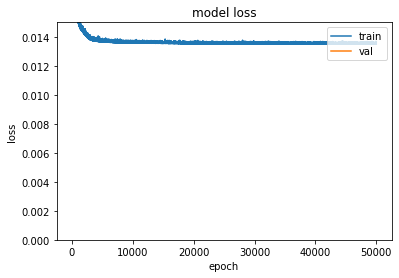

In [ ]:
epochs = [i for i in range(EPOCHS)]
plt.axes(ylim=(0., 0.015))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
prediction_train = neural_net.predict(x_train.values)
prediction_val = neural_net.predict(x_val.values)

# metrics
r2_train = r_2(y_train.values, prediction_train)
rmae_train = rmae(y_train.values, prediction_train)
raae_train = raae(y_train.values, prediction_train)

PREDICTION_TRAIN = recover_output(prediction_train, y_min_max)
mape_train = mape(Y_train.values, PREDICTION_TRAIN)
mpe_train, _ = mpe(Y_train.values, PREDICTION_TRAIN)

r2_val = r_2(y_val.values, prediction_val)
rmae_val = rmae(y_val.values, prediction_val)
raae_val = raae(y_val.values, prediction_val)

PREDICTION_VAL = recover_output(prediction_val, y_min_max)
mape_val = mape(Y_val.values, PREDICTION_VAL)
mpe_val, _ = mpe(Y_val.values, PREDICTION_VAL)

metrics = {'R2': [r2_train, r2_val],
           'RMAE': [rmae_train, rmae_val],
           'RAAE': [raae_train, rmae_val],
           'MAPE': [mape_train, mape_val],
           'MPE': [mpe_train, mpe_val]}
metrics_df = pd.DataFrame(metrics, index=['train', 'val'])
metrics_df.head()

,R2,RMAE,RAAE,MAPE,MPE
train,0.988971,0.099963,0.029417,4.481064,24.141277
val,0.972480,0.252280,0.252280,6.066769,33.026807


In [ ]:
prediction_test = neural_net.predict(x_test.values)

r2_test = r_2(y_test.values, prediction_test)
rmae_test= rmae(y_test.values, prediction_test)
raae_test = raae(y_test.values, prediction_test)

PREDICTION_TEST = recover_output(prediction_test, y_min_max)
mape_test = mape(Y_test.values, PREDICTION_TEST)
mpe_test, _ = mpe(Y_test.values, PREDICTION_TEST)

metrics = {'R2': [r2_train, r2_val, r2_test],
           'RMAE': [rmae_train, rmae_val, rmae_test],
           'RAAE': [raae_train, raae_val, raae_test],
           'MAPE': [mape_train, mape_val, mape_test],
           'MPE': [mpe_train, mpe_val, mpe_test]}
metrics_df = pd.DataFrame(metrics, index=['train', 'val', 'test'])
metrics_df.head()

,R2,RMAE,RAAE,MAPE,MPE
train,0.988971,0.099963,0.029417,4.481064,24.141277
val,0.972480,0.252280,0.069448,6.066769,33.026807
test,0.970069,0.282665,0.121426,7.100456,23.904591
